In [1]:
!pip install serpapi

In [2]:
!pip install requests beautifulsoup4 pandas serpapi


In [22]:
!pip install google-search-results

In [58]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from serpapi import search
import warnings

# Suppress warnings about character decoding issues
warnings.filterwarnings('ignore', message='Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.')

# Your SerpApi API key
SERP_API_KEY = "d99d2436d6ccbacb0d6625e19fd27496aa2e928bf5052449c00133b2a508c7d2"

# Define search parameters
params = {
    "api_key": SERP_API_KEY,
    "engine": "google_news",
    "q": "carbon emissions of AI",
    "location": "United States",
    "google_domain": "google.com",
    "gl": "us",
    "hl": "en",
    "num": 10
}

# Perform the search
try:
    search_results = search(params)
    news_results = search_results.get('news_results', [])
except Exception as e:
    print(f"Error performing search: {e}")
    news_results = []

# Extract URLs from search results
urls = [result['link'] for result in news_results if 'link' in result]

# Prepare a list to hold all articles
all_articles = []

# Extract data from each URL
for url in urls:
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        title_tag = soup.find('title')
        title = title_tag.get_text(strip=True) if title_tag else 'No Title'
        
        description_tag = soup.find('meta', attrs={'name': 'description'}) or soup.find('p')
        description = description_tag['content'] if description_tag and description_tag.has_attr('content') else description_tag.get_text(strip=True) if description_tag else 'No Description'

        article_info = {
            'title': title,
            'description': description,
            'url': url
        }
        all_articles.append(article_info)
    except requests.exceptions.RequestException:
        pass  # Suppress the error message and continue
    except Exception:
        pass  # Suppress the error message and continue

# Convert the list of articles to a DataFrame
df = pd.DataFrame(all_articles)

# Display the DataFrame
print(df.head(10))

# Save the DataFrame to a CSV file
df.to_csv('carbon_emission_ai_articles.csv', index=False)


                                               title  \
0  Microsoft’s AI obsession is jeopardizing its c...   
1                       Bloomberg - Are you a robot?   
2  AI's carbon footprint is bigger than you think...   
3    Amazon: AI spots product defects, reduces waste   
4                AI's Hunger For Energy - Dataconomy   
5  Microsoft's AI Push Jeopardizes Climate Goals ...   
6              Featured news and headlines | KU News   
7  AI emissions are fueling a new doomerism. This...   
8  AI may accelerate job losses and carbon emissi...   
9  4 best practices for using AI to reduce carbon...   

                                         description  \
0  Microsoft’s carbon footprint is growing as it ...   
1  To continue, please click the box below to let...   
2  Generating one image takes as much energy as f...   
3  AI-enabled technology ensures customers receiv...   
4  AI's hunger for energy grows with tech evoluti...   
5  The software giant's supply chain is respons

In [59]:
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
print(stopwords)

{'up', 'who', "hasn't", 'some', 'than', "mightn't", 'to', 'm', 'or', 'ma', "you're", "didn't", 'an', 'which', 'whom', 'where', 'how', 's', 'all', 'yours', 'ours', 'between', 'having', 'their', 'has', 'same', 'until', 'our', "doesn't", 'what', 'being', 'shouldn', "won't", "shouldn't", 'isn', 'as', 'while', 'now', 'if', 'itself', 'further', 'you', "isn't", 'herself', 'were', 'because', 'nor', 'did', 'not', 'my', 'aren', 'under', 'hadn', 'a', "wasn't", 'just', 'these', "hadn't", 'll', "it's", 'yourself', 'that', 'such', "wouldn't", 'below', 'in', 'for', 'both', "mustn't", 'of', 'o', "you'd", 'are', 'against', 'very', 'out', 'hasn', 'mightn', 'myself', 'been', 'am', 'when', "couldn't", 'its', 'no', 'haven', 'why', 'he', 'his', 'again', 'at', 't', 'ourselves', 'down', 'wasn', "weren't", 'from', 'during', 'y', 'ain', 'i', 'but', 'they', 'won', 'have', 'this', 'here', "don't", 'with', 're', 'hers', 'themselves', "needn't", 'can', 'those', 'more', 'yourselves', 'own', 'your', 'most', 'any', 'i

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mouni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
import regex as re
def tokenize(text):
    return re.findall(r'[\w-]*[a-z|A-Z][\w-]*', text)


In [61]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]


In [62]:
pipeline = [str.lower, tokenize, remove_stop]
def prepare(text, pipeline):
    tokens = text
    for fun in pipeline:
        tokens = fun(tokens)
    return tokens


In [63]:
df['tokens'] = df['title'].apply(prepare, pipeline=pipeline)

In [64]:
from collections import Counter
counter = Counter()
df['tokens'].map(counter.update)
freq_df = pd.DataFrame.from_dict(counter, 
orient='index', columns=['freq'])
freq_df = freq_df.query('freq >= 1')
freq_df.index.name = 'token'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(10)

,freq
token,
ai,54
emissions,35
|,35
carbon,30
climate,19
microsoft,14
reduce,9
energy,8
technology,6


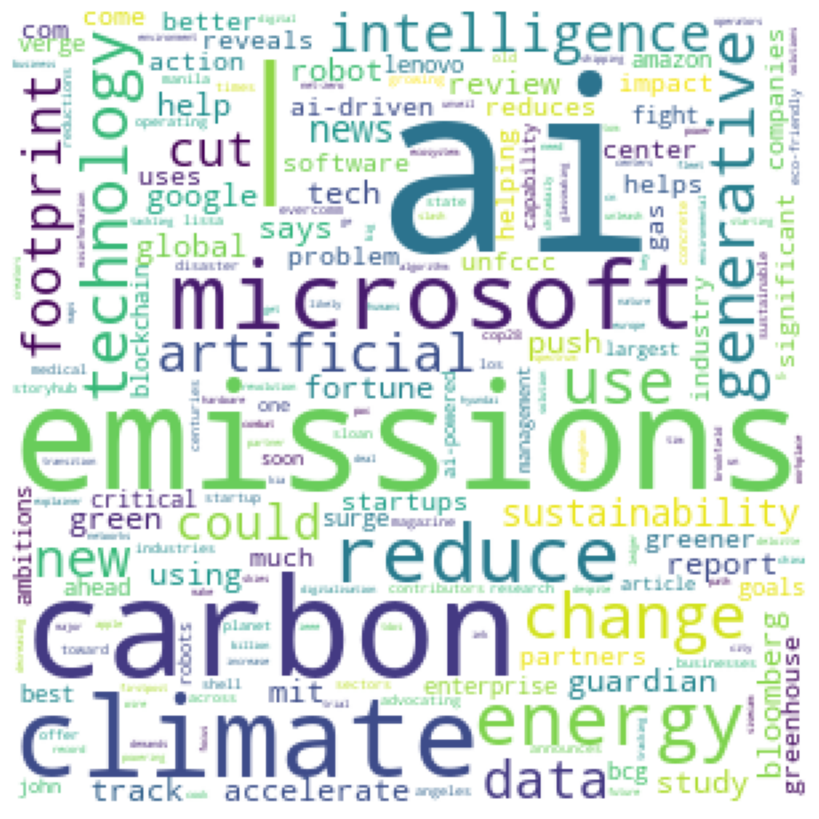

In [65]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
wc = WordCloud(background_color='white', width = 300, height=300, 
margin=2)
wc.fit_words(freq_df['freq'].to_dict() )
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [66]:
import numpy as np
def compute_idf(df, column='tokens', preprocess=None, min_df=1):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))
 # count tokens
    counter = Counter()
    df[column].map(update)
# create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df
idf_df = compute_idf(df)

In [67]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
freq_df.head()


,freq,tfidf
token,,
ai,54,22.217553
emissions,35,28.256614
|,35,32.504244
carbon,30,28.844475
climate,19,27.973854


# sentiment analysis

In [68]:
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

In [69]:
#Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Create a function to get Polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Now we create a new column for what we just did and add it to the Tweet_df dataframe
df['Subjectivity'] = df['title'].apply(getSubjectivity)
df['Polarity'] = df['title'].apply(getPolarity)

#Now display data
df.head()

,title,description,url,tokens,Subjectivity,Polarity
0,Microsoft’s AI obsession is jeopardizing its c...,Microsoft’s carbon footprint is growing as it ...,https://www.theverge.com/2024/5/15/24157496/mi...,"[microsoft, ai, obsession, jeopardizing, clima...",0.0,0.0
1,Bloomberg - Are you a robot?,"To continue, please click the box below to let...",https://www.bloomberg.com/news/articles/2024-0...,"[bloomberg, robot]",0.0,0.0
2,AI's carbon footprint is bigger than you think...,Generating one image takes as much energy as f...,https://www.technologyreview.com/2023/12/05/10...,"[ai, carbon, footprint, bigger, think, |, mit,...",0.5,0.0
3,"Amazon: AI spots product defects, reduces waste",AI-enabled technology ensures customers receiv...,https://www.aboutamazon.com/news/innovation-at...,"[amazon, ai, spots, product, defects, reduces,...",0.0,-0.2
4,AI's Hunger For Energy - Dataconomy,AI's hunger for energy grows with tech evoluti...,https://dataconomy.com/2024/06/07/ais-hunger-f...,"[ai, hunger, energy, dataconomy]",0.0,0.0


In [70]:
#Group the range of Polarity to different categories
def getInsight(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"
    
df["Insight"] = df["Polarity"].apply(getInsight)

df.head(10)

,title,description,url,tokens,Subjectivity,Polarity,Insight
0,Microsoft’s AI obsession is jeopardizing its c...,Microsoft’s carbon footprint is growing as it ...,https://www.theverge.com/2024/5/15/24157496/mi...,"[microsoft, ai, obsession, jeopardizing, clima...",0.000000,0.000000,Neutral
1,Bloomberg - Are you a robot?,"To continue, please click the box below to let...",https://www.bloomberg.com/news/articles/2024-0...,"[bloomberg, robot]",0.000000,0.000000,Neutral
2,AI's carbon footprint is bigger than you think...,Generating one image takes as much energy as f...,https://www.technologyreview.com/2023/12/05/10...,"[ai, carbon, footprint, bigger, think, |, mit,...",0.500000,0.000000,Neutral
3,"Amazon: AI spots product defects, reduces waste",AI-enabled technology ensures customers receiv...,https://www.aboutamazon.com/news/innovation-at...,"[amazon, ai, spots, product, defects, reduces,...",0.000000,-0.200000,Negative
4,AI's Hunger For Energy - Dataconomy,AI's hunger for energy grows with tech evoluti...,https://dataconomy.com/2024/06/07/ais-hunger-f...,"[ai, hunger, energy, dataconomy]",0.000000,0.000000,Neutral
5,Microsoft's AI Push Jeopardizes Climate Goals ...,The software giant's supply chain is responsib...,https://www.cnet.com/tech/mobile/microsofts-ai...,"[microsoft, ai, push, jeopardizes, climate, go...",0.000000,0.000000,Neutral
6,Featured news and headlines | KU News,The latest news and information for the Univer...,https://news.ku.edu/news/article/study-ai-writ...,"[featured, news, headlines, |, ku, news]",0.000000,0.000000,Neutral
7,AI emissions are fueling a new doomerism. This...,The challenge lies in ensuring that the effici...,https://fortune.com/2023/12/12/ai-emissions-do...,"[ai, emissions, fueling, new, doomerism, time,...",0.454545,0.136364,Positive
8,AI may accelerate job losses and carbon emissi...,But economists say it could be offset by the c...,https://www.theguardian.com/technology/article...,"[ai, may, accelerate, job, losses, carbon, emi...",1.000000,-0.600000,Negative
9,4 best practices for using AI to reduce carbon...,Deploying artificial intelligence applications...,https://www.greenbiz.com/article/4-things-cons...,"[best, practices, using, ai, reduce, carbon, e...",0.300000,1.000000,Positive


In [71]:
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

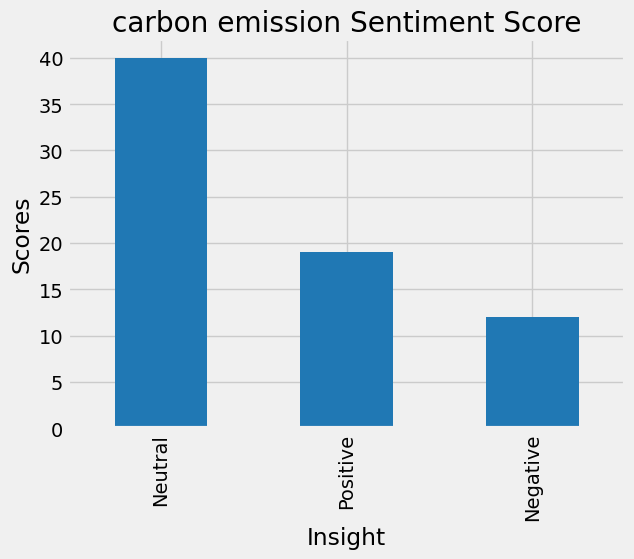

In [72]:
#Plot the values count of sentiment
plt.title("carbon emission Sentiment Score")
plt.xlabel("Sentiment")
plt.ylabel("Scores")
plt.rcParams["figure.figsize"] = (10,8)
df["Insight"].value_counts().plot(kind="bar", color="#2078B4")
plt.show()

In [73]:
import gensim
from gensim import corpora

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(df['tokens'])

# Filter out words that occur less than 3 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=3, no_above=0.5)

# Create a corpus object
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# Apply LDA
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.237*"microsoft" + 0.181*"emissions" + 0.129*"carbon" + 0.087*"data" + 0.070*"|"')
(1, '0.221*"|" + 0.129*"climate" + 0.090*"energy" + 0.065*"intelligence" + 0.065*"artificial"')
(2, '0.117*"|" + 0.082*"robot" + 0.082*"bloomberg" + 0.082*"review" + 0.082*"mit"')
(3, '0.222*"emissions" + 0.217*"carbon" + 0.109*"reduce" + 0.066*"|" + 0.054*"cut"')
(4, '0.174*"climate" + 0.118*"change" + 0.117*"carbon" + 0.093*"emissions" + 0.087*"|"')
